In [1]:
from pathlib import Path
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
def load_json_file(file_path):
    """
    Load a JSON file and return its contents as a dictionary.

    :param file_path: Path to the JSON file.
    :return: Parsed JSON content as a dictionary.
    :raises: FileNotFoundError, json.JSONDecodeError
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")
        raise
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file '{file_path}'.")
        print(f"Details: {e}")
        raise


In [3]:
class ComveResult:
    def __init__(self, results_json):
        self.results_json = results_json
    
    @property
    def args(self):
        return self.results_json["args"]
    
    @property
    def model(self) -> dict:
        return self.results_json["model"]
    
    @property
    def examples(self) -> dict:
        return self.results_json["samples"]
    
    @property
    def explainer(self) -> str:
        return self.results_json["explainer"]
    
    @property
    def tests(self) -> list[str]:
        return self.results_json["tests"]
    
    def __repr__(self):
        model = f"{self.model["full_model_name"]} ({self.model["dtype"]})"
        return f"Model: {model}\nTests: {self.tests}\nExplainer: {self.explainer})\nExamples: {len(self.examples)}\nArgs: {self.args}"

    def examples_names(self) -> list[str]:
        return list(self.examples.keys())

    def get_example(self, example_name: str) -> dict:
        return self.examples[example_name]
    
    def get_variable(self, variable):
        cc_shap_cot_values = []
        for example_name in self.examples_names():
            cc_shap_score = self.get_example(example_name)[variable]
            cc_shap_cot_values.append(float(cc_shap_score))

        return np.array(cc_shap_cot_values)

    def describe(self, variable):
        variable_values = self.get_variable(variable)

        print("Mean: ", variable_values.mean())
        print("Min: ", variable_values.min())
        print("Max: ", variable_values.max())
        print("Std dev: ", variable_values.std())
    
    def mean(self, variable):
        variable_values = self.get_variable(variable)
        return variable_values.mean()

    def boxplot(self, variable):
        cc_shap_cot_values = self.get_variable(variable)

        plt.boxplot(cc_shap_cot_values, orientation="horizontal")
        plt.xlim((-1.0, 1.0))
        plt.show()

In [4]:
class ComveResults:
    def __init__(self, result_files: list[Path]):
        self.result_files = result_files
    
    def load(self):
        for file in self.result_files:
            result_json = load_json_file(file)
            yield ComveResult(result_json)
    
    def compare(self, variable, metric):
        variable_values = []
        for idx, result_file in enumerate(self.result_files):
            result_json = load_json_file(result_file)
            variable_value = ComveResult(result_json).get_variable(variable)
            metric_value = metric(variable_value)
            variable_values.append(metric_value)
        return variable_values

In [5]:
result_dir = Path("results_json")
partition = result_dir / "comve_gpt2_100_partition.json"

print(ComveResult(load_json_file(partition)))

Model: gpt2 (torch.float16)
Tests: ['cc_shap-posthoc', 'cc_shap-cot']
Explainer: {'type': 'shap.explainers.Partition()', 'max_evaluations': 500})
Examples: 100
Args: Namespace(c_task='comve', model_name='gpt2', number_of_samples=100, explainer_type='partition', classify_pred=False)


In [6]:
def mean_metric(values):
    return np.mean(values)

def max_metric(values):
    return np.max(values)

def min_metric(values):
    return np.min(values)

def std_metric(values):
    return np.std(values)

In [7]:
result_dir = Path("results_json")
partition = result_dir / "comve_gpt2_100_partition.json"
permutation = result_dir / "comve_gpt2_100_permutation.json"
permutation = partition

comve_results = ComveResults([partition, permutation])

In [12]:
test_to_compare = "cc_shap-posthoc"

for result in comve_results.load():
    print("Explainer:", result.explainer["type"])
    result.describe(test_to_compare)
    print("")

Explainer: shap.explainers.Partition()
Mean:  0.03459999999999999
Min:  -0.35
Max:  0.31
Std dev:  0.1443981994347575

Explainer: shap.explainers.Partition()
Mean:  0.03459999999999999
Min:  -0.35
Max:  0.31
Std dev:  0.1443981994347575



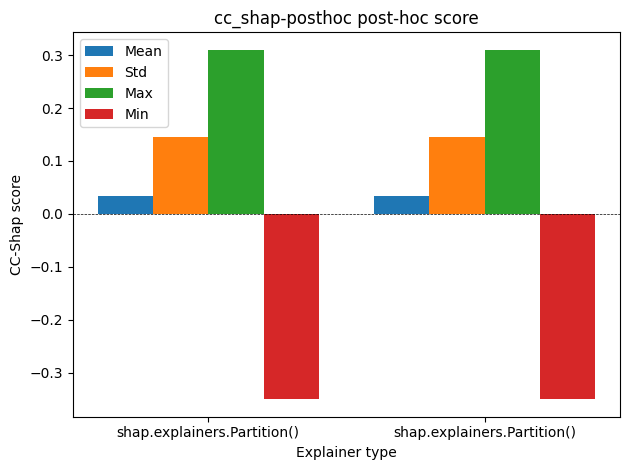

In [9]:
test_to_compare = "cc_shap-posthoc"
metrics = {
    "Mean": comve_results.compare(test_to_compare, mean_metric),
    "Std": comve_results.compare(test_to_compare, std_metric),
    "Max": comve_results.compare(test_to_compare, max_metric),
    "Min": comve_results.compare(test_to_compare, min_metric),
}

explainer_types = list(map(lambda x: x.explainer["type"], comve_results.load()))

x = np.arange(len(explainer_types))
num_metrics = len(metrics)
width = 0.8 / num_metrics

# Create the plot
fig, ax = plt.subplots()

# Plot each metric as a separate group of bars
for i, (metric_name, metric_values) in enumerate(metrics.items()):
    bar_positions = x + (i - num_metrics / 2) * width + width / 2
    ax.bar(bar_positions, metric_values, width, label=metric_name)

# Add labels, title, and legend
ax.set_xlabel("Explainer type")
ax.set_ylabel("CC-Shap score")
ax.set_title(f"{test_to_compare} post-hoc score")
ax.set_xticks(x)
ax.set_xticklabels(explainer_types)
ax.axhline(0.0, color="black", linestyle='--', linewidth=0.5)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

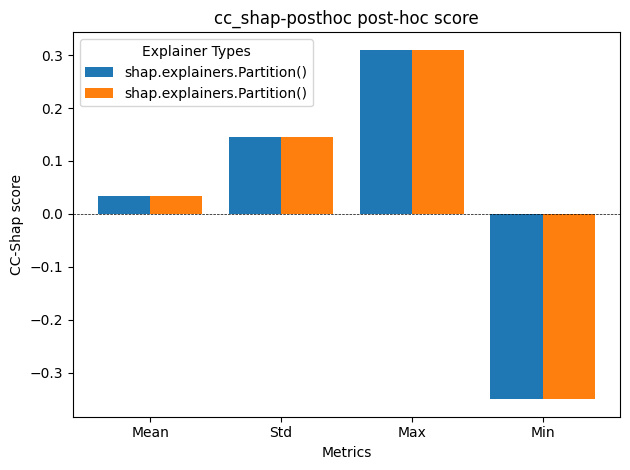

In [10]:
# Setup paths and results
result_dir = Path("results_json")
partition = result_dir / "comve_gpt2_100_partition.json"
permutation = result_dir / "comve_gpt2_100_permutation.json"
permutation = partition  # This looks intentional in your original code

comve_results = ComveResults([partition, permutation])

# Metrics to compare
test_to_compare = "cc_shap-posthoc"
metrics = {
    "Mean": comve_results.compare(test_to_compare, mean_metric),
    "Std": comve_results.compare(test_to_compare, std_metric),
    "Max": comve_results.compare(test_to_compare, max_metric),
    "Min": comve_results.compare(test_to_compare, min_metric),
}

# Explainer types
explainer_types = list(map(lambda x: x.explainer["type"], comve_results.load()))

# Prepare data for grouped bar chart
x = np.arange(len(metrics))  # Metric locations on the x-axis
num_explainers = len(explainer_types)
width = 0.8 / num_explainers  # Adjust bar width based on the number of explainers

# Create the plot
fig, ax = plt.subplots()

# Plot bars for each explainer
for i, explainer_type in enumerate(explainer_types):
    metric_values = [metrics[metric_name][i] for metric_name in metrics]  # Get values for this explainer
    bar_positions = x + (i - num_explainers / 2) * width + width / 2  # Adjust positions for each explainer
    ax.bar(bar_positions, metric_values, width, label=explainer_type)

# Add labels, title, and legend
ax.set_xlabel("Metrics")
ax.set_ylabel("CC-Shap score")
ax.set_title(f"{test_to_compare} post-hoc score")
ax.set_xticks(x)
ax.set_xticklabels(metrics.keys())  # Metric names as x-axis labels
ax.axhline(0.0, color="black", linestyle='--', linewidth=0.5)
ax.legend(title="Explainer Types")

# Show the plot
plt.tight_layout()
plt.show()